# RoI Utility Example

In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from roi_util import ROIAlign, ROIPool, nms

%matplotlib inline

## 1 RoIAlign & RoIPool

### 1.1 Creating an RoIAlign/RoIPool layer

In [2]:
output_size = (4, 2)
spatial_scale = 20.0 / 320.0
sampling_ratio = 0

roi_align = ROIAlign(output_size, spatial_scale, sampling_ratio).cuda()
roi_pool = ROIPool(output_size, spatial_scale).cuda()

### 1.2 Fake some data

In [3]:
# PyTorch feature map. Shape of `img` is (batch size, number of channels, height, width).
img = torch.zeros([3, 3, 20, 32]).type(torch.float32).cuda()
img[0, :, 10:, :] = 1.
img[1, :, :10, :] = 1.
img[2, :, :, 10:] = 1.

In [4]:
# Shape of Tensor `roi` is (N, 5).
# In which 5 stands for (index of element in the batch, x1, y1, x2, y2).
roi_coords = np.array([[0, 10.0, 75.85, 116.5, 198.3], 
                       [1, 10, 26.7, 216.1, 198], 
                       [2, 94.2, 115, 180, 301.9], 
                       [0, 94.2, 115, 180, 301.9]])
roi_coords = torch.Tensor(roi_coords).cuda()

### 1.3 Call the RoIAlign/RoIPool object to get alignment/pooling results

In [ ]:
roi_aligned_map = roi_align(img, roi_coords)
roi_pooled_map = roi_pool(img, roi_coords)

### 1.4 Visualization

In [6]:
# Plot the RoI, its bins and the grids in the feature map.
def plot_roi(img, roi_coords, output_size, spatial_scale):
    x1, y1, x2, y2 = roi_coords[1:5]
    img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), thickness=2)
    xs = np.linspace(x1, x2, output_size[1] + 1)
    ys = np.linspace(y1, y2, output_size[0] + 1)
    for i in range(output_size[0]):
        cv2.line(img, (int(x1), int(ys[i])), (int(x2), int(ys[i])), (0, 255, 0), thickness=2)
    for i in range(output_size[1]):
        cv2.line(img, (int(xs[i]), int(y1)), (int(xs[i]), int(y2)), (0, 255, 0), thickness=2)
    for i in range(img.shape[0]):
        y = int(i / spatial_scale)
        cv2.line(img, (0, y), (512, y), (0, 255, 255), thickness=1)
    for i in range(img.shape[1]):
        x = int(i / spatial_scale)
        cv2.line(img, (x, 0), (x, 320), (0, 255, 255), thickness=1)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


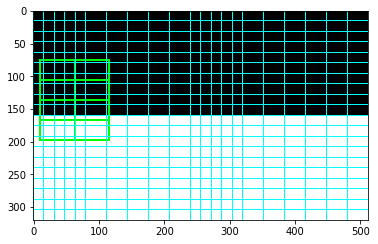

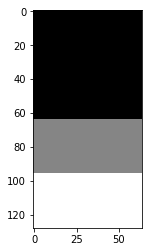

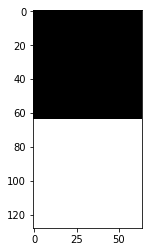

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


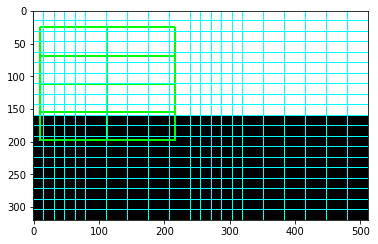

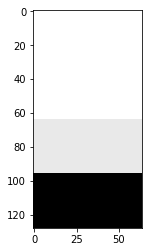

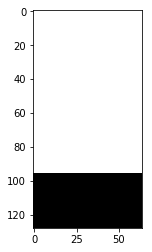

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


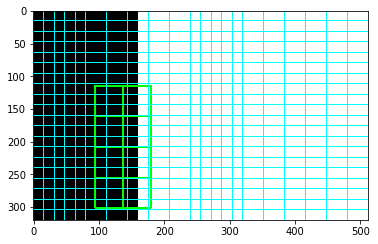

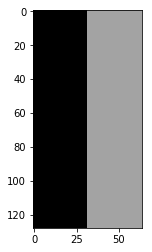

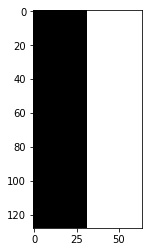

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


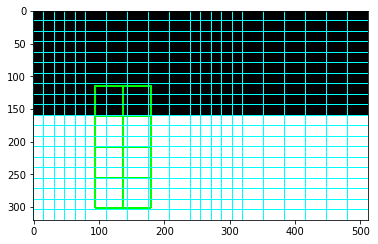

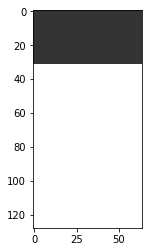

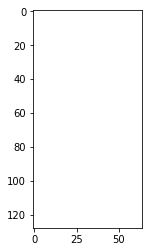

In [7]:
roi_aligned_map_np = dict()
roi_pooled_map_np = dict()
img_np = dict()

# Visualize each RoI and its alignment/pooling results.
for i in range(roi_coords.shape[0]):
    roi_batch_index = int(roi_coords[i][0])
    img_np[i] = img[roi_batch_index].cpu().numpy().transpose([1, 2, 0])
    img_np[i] = cv2.resize(img_np[i], (512, 320), interpolation=cv2.INTER_NEAREST)
    img_np[i] = plot_roi(img_np[i], roi_coords[i].cpu().numpy(), output_size, spatial_scale)
    roi_aligned_map_np[i] = roi_aligned_map[i].cpu().numpy().transpose([1, 2, 0])
    roi_aligned_map_np[i] = cv2.resize(roi_aligned_map_np[i], (64, 128), interpolation=cv2.INTER_NEAREST)
    roi_pooled_map_np[i] = roi_pooled_map[i].cpu().numpy().transpose([1, 2, 0])
    roi_pooled_map_np[i] = cv2.resize(roi_pooled_map_np[i], (64, 128), interpolation=cv2.INTER_NEAREST)
    
    # Show the feature map.
    plt.imshow(img_np[i])
    plt.show()
    # Show the RoI alignment result.
    plt.imshow(roi_aligned_map_np[i])
    plt.show()
    # And show the RoI pooling result.
    plt.imshow(roi_pooled_map_np[i])
    plt.show()

## 2 Non-Maximum Suppression

### 2.1 Fake some data

In [8]:
# Shape of Tensor `dets` is (N, 4).
# In which 4 stands for (x1, y1, x2, y2).
dets = np.array([[10.0, 75.85, 116.5, 198.3], 
                 [10, 26.7, 216.1, 198], 
                 [94.2, 115, 180, 301.9]])
dets = torch.Tensor(dets).cuda()
scores = torch.Tensor(np.array([0.8, 0.78, 0.85])).cuda()

### 2.2 Directly call nms(dets, scores, overlap_threshold)

In [9]:
# Return value is a tensor containing indices of the boxes left.
result = nms(dets, scores, 0.4)
print(result)

result = nms(dets, scores, 0.3)
print(result)

tensor([0, 1, 2], device='cuda:0')
tensor([0, 2], device='cuda:0')


### 2.3 Visualization

In [10]:
# Plot the detected boxes, its bins and the grids in the feature map.
def plot_boxes(img_size, boxes, scores):
    img = np.zeros([img_size[1], img_size[0], 3]).astype(np.float32)
    for i in range(len(boxes)):
        x1, y1, x2, y2 = boxes[i, :4]
        img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), thickness=2)
        img = cv2.putText(img, "{:.2f}".format(scores[i]), (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0),1)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


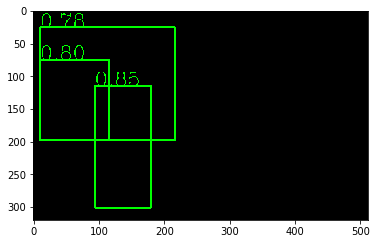

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


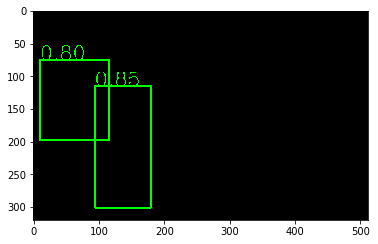

In [11]:
# Plot all boxes.
img_all = plot_boxes((512, 320), dets, scores)
plt.imshow(img_all)
plt.show()

# And plot the boxes after NMS.
img_nms = plot_boxes((512, 320), dets[result], scores[result])
plt.imshow(img_nms)
plt.show()